In [1]:
!pip install langchain_community tiktoken langchain-groq langchain-mistralai rank_bm25 langchainhub chromadb langchain langgraph tavily-python langchain-huggingface arxiv wikipedia -q

In [2]:
import os
from google.colab import userdata
from langchain_community.document_loaders import WebBaseLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import Chroma
from langchain_huggingface import HuggingFaceEmbeddings
from langchain.retrievers.multi_query import MultiQueryRetriever
from rank_bm25 import BM25Okapi
from langchain_core.prompts import ChatPromptTemplate
from langchain_groq import ChatGroq
from langchain_mistralai import ChatMistralAI
from langchain_core.output_parsers import StrOutputParser
from langchain_community.utilities import ArxivAPIWrapper,WikipediaAPIWrapper
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_community.tools import ArxivQueryRun,WikipediaQueryRun
from langchain.retrievers import ContextualCompressionRetriever
from langchain.retrievers.document_compressors import LLMChainExtractor


In [3]:
os.environ["TAVILY_API_KEY"] = userdata.get('TAVILY_API_KEY')
os.environ["GROQ_API_KEY"] = userdata.get('GROQ_API_KEY')
os.environ["MISTRAL_API_KEY"] = userdata.get('MISTRAL_API_KEY')

In [4]:
urls = ["https://medium.com/@muddassir10/machine-learning-based-price-estimation-a-practical-approach-7164b35d10fd"]

docs = [WebBaseLoader(url).load() for url in urls]
docs = [doc for doclist in docs for doc in doclist]

In [5]:
splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=500, chunk_overlap=30
)
splitted_docs = splitter.split_documents(docs)

In [6]:
from langchain_mistralai import MistralAIEmbeddings
vector_db = Chroma.from_documents(
    documents=splitted_docs,
    collection_name='agentic-rag',
    embedding=HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2"),
    persist_directory='./chroma_langchain_db'
)
base_retriever = vector_db.as_retriever()

In [7]:
retriever_llm = ChatGroq(model='llama-3.2-1b-preview')

compressor = LLMChainExtractor.from_llm(retriever_llm)
retriever = ContextualCompressionRetriever(
    base_compressor=compressor, base_retriever=base_retriever
)

retriever.invoke('what are the documents about?')[0]

Document(metadata={'description': 'Our team embarked on a mission to enhance price estimation across diverse domains, driven by a commitment to innovation, data-driven insights, and practical problem-solving. In this blog, we’ll take…', 'language': 'en', 'source': 'https://medium.com/@muddassir10/machine-learning-based-price-estimation-a-practical-approach-7164b35d10fd', 'title': 'Machine Learning-Based Price Estimation: A Practical Approach | by Mudassir Junejo | Medium'}, page_content='*PRELIMINARY MODEL NAVIGATION: Start with a basic Linear Regression model and assess initial scores.')

In [8]:
def retrieve_docs(query):
  return retriever.invoke(query)

def rerank_docs(query,docs):
  tokenized_docs = [doc.page_content.split() for doc in docs]
  bm25 = BM25Okapi(tokenized_docs)
  scores = bm25.get_scores(query[0].split())
  ranked_docs = sorted(zip(docs,scores),key=lambda x:x[1],reverse=True)
  docs = [x[0] for x in ranked_docs]
  return docs[:3]

In [9]:
query = 'what are the documents about?'
#rerank_docs('what are the documents about?',retriever.invoke('what are the documents about?')[0])
retriever.invoke(query)

[Document(metadata={'description': 'Our team embarked on a mission to enhance price estimation across diverse domains, driven by a commitment to innovation, data-driven insights, and practical problem-solving. In this blog, we’ll take…', 'language': 'en', 'source': 'https://medium.com/@muddassir10/machine-learning-based-price-estimation-a-practical-approach-7164b35d10fd', 'title': 'Machine Learning-Based Price Estimation: A Practical Approach | by Mudassir Junejo | Medium'}, page_content='*API Craftsmanship with Flask and Intuitive Webpages:Beyond impressive scores, we created an API using Flask and user-friendly webpages (HTML, CSS, JS) for seamless user interaction.'),
 Document(metadata={'description': 'Our team embarked on a mission to enhance price estimation across diverse domains, driven by a commitment to innovation, data-driven insights, and practical problem-solving. In this blog, we’ll take…', 'language': 'en', 'source': 'https://medium.com/@muddassir10/machine-learning-base

In [10]:
rag_llm = ChatMistralAI(model='mistral-large-latest',api_key=os.environ['MISTRAL_API_KEY'],max_tokens=1024)
#rag_llm = ChatGroq(model='llama3-groq-8b-8192-tool-use-preview',max_tokens=1024)

In [11]:
from langchain import hub
prompt_str = """
You are a helpful assistant specialized in question-answering tasks. Follow these instructions carefully:

1. Use the provided documents to answer the query.
2. If each of the documents is not relevant to the query, respond with exactly (do not say anyother thing just say this): "Documents Not Relevant".
3. Avoid hallucinating information. Base your answers only on the documents provided or respond with exactly (do not say anyother thing just say this): "Documents Not Relevant".
4. Focus on providing only the major and most relevant details in your response.

Query: {query}
Documents: {docs}
Answer:
"""
prompt = ChatPromptTemplate.from_template(prompt_str)

In [12]:
rag_chain =  prompt |rag_llm| StrOutputParser()

In [13]:
query = "what is Cosine Similarity?"
rag_chain.invoke({'query':query,'docs':rerank_docs(query,retrieve_docs(query))})

'Documents Not Relevant'

In [16]:
arxiv_wrapper = ArxivAPIWrapper(top_k_results=1,doc_content_chars_max=300)
wikipedia_wrapper = WikipediaAPIWrapper(top_k_results=1,doc_content_chars_max=300)

arxiv_tool = ArxivQueryRun(api_wrapper=arxiv_wrapper)
wikipedia_tool = WikipediaQueryRun(api_wrapper=wikipedia_wrapper)

tavily_tool = TavilySearchResults(max_results=2,include_raw_content=False)

tools = [tavily_tool]

In [17]:
query = "What is agentic ai?".lower()
llm_with_tools = rag_llm.bind_tools(tools=tools)
x = llm_with_tools.invoke(query)

In [18]:
x

AIMessage(content='Agentic AI refers to artificial intelligence systems that are designed to act autonomously and proactively on behalf of users or other entities. These AI agents can perform tasks, make decisions, and interact with their environment without requiring constant human intervention. Key characteristics of agentic AI include:\n\n1. **Autonomy**: The ability to operate independently and make decisions without human input.\n2. **Proactivity**: Taking initiative to perform tasks or achieve goals without being explicitly instructed to do so.\n3. **Adaptability**: Learning from experience and adapting to new situations or changes in the environment.\n4. **Interactivity**: Communicating and collaborating with users, other AI agents, or systems to achieve objectives.\n5. **Goal-Oriented**: Focused on achieving specific goals or performing tasks that align with user needs or organizational objectives.\n\nExamples of agentic AI include virtual assistants like Siri or Alexa, which c

In [23]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph,START,END
from langgraph.graph.message import add_messages

class State(TypedDict):
  messages:Annotated[list,add_messages]

def retrieve(state: State):
  messages = state['messages']
  query = messages[0].content
  #docs = base_retriever.invoke(query)
  docs = retriever.invoke(query)
  #docs_str = " ".join([doc[0] for doc in ranked_docs])

  return {'messages' : state['messages'] + [{'content':"\n\n".join([doc.page_content for doc in docs]),'role':'system'}]}

def chat(state: State):
  messages = state['messages']
  query = messages[0].content
  docs = "\n".join([msg.content for msg in messages[1:]])
  response = rag_chain.invoke({'query':query,'docs':docs})

  if "Documents Not Relevant." in response or "Documents Not Relevant" in response:
    res = llm_with_tools.invoke(query).content
    return {'messages' : [{'content':"\n"+str(res),'role':'ai'}]}
  else:
    return {'messages' : [{'content':"\n"+response,'role':'ai'}]}

In [24]:
from langgraph.prebuilt import ToolNode,tools_condition

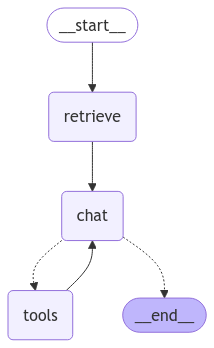

In [25]:
tool_node = ToolNode(tools=tools)
builder = StateGraph(State)
builder.add_edge(START,'retrieve')
builder.add_node('retrieve',retrieve)
builder.add_node('chat',chat)
builder.add_edge('retrieve','chat')
builder.add_node('tools',tool_node)
builder.add_conditional_edges('chat',tools_condition)
builder.add_edge('tools','chat')
graph = builder.compile()

from IPython.display import Image,display
try:
  display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
  pass

In [26]:
you = "what are these documents about?"
events = graph.stream(
    {'messages': [('user',you)]},stream_mode='values'
)
for event in events:
  event['messages'][-1].pretty_print()

================================ Human Message =================================

what are these documents about?
================================ System Message ================================

Machine Learning-Based Price Estimation: A Practical Approach

Machine Learning-Based Price Estimation: A Practical Approach | by Mudassir Junejo | Medium

Machine Learning-Based Price Estimation: A Practical Approach | by Mudassir Junejo | Medium | Open in appSign upSign in | Introduction:Our team embarked on a mission to enhance price estimation across diverse domains, driven by a commitment to innovation, data-driven insights, and practical problem-solving.

Machine Learning-Based Price Estimation: A Practical Approach | by Mudassir Junejo | Medium
================================== Ai Message ==================================


These documents are about a topic titled "Machine Learning-Based Price Estimation: A Practical Approach," written by Mudassir Junejo on Medium. The content focuses

In [27]:
you = "what is cosine similarity?"
events = graph.stream(
    {'messages': [('user',you)]},stream_mode='values'
)
for event in events:
  event['messages'][-1].pretty_print()

================================ Human Message =================================

what is cosine similarity?
================================ System Message ================================

Machine Learning-Based Price Estimation: A Practical Approach | by Mudassir Junejo | Medium
Machine Learning-Based Price Estimation: A Practical Approach
Machine Learning-Based Price Estimation: A Practical Approach
Machine Learning-Based Price Estimation: A Practical Approach | by Mudassir Junejo | Medium
Machine Learning-Based Price Estimation: A Practical Approach | by Mudassir Junejo | Medium
Machine Learning-Based Price Estimation: A Practical Approach | by Mudassir Junejo | Medium
Machine Learning-Based Price Estimation: A Practical Approach | by Mudassir Junejo | Medium
Machine Learning-Based Price Estimation: A Practical Approach | by Mudassir Junejo | Medium
Machine Learning-Based Price Estimation: A Practical Approach | by Mudassir Junejo | Medium
Machine Learning-Based Price Estimation: 

In [28]:
x = graph.invoke({'messages':"what is bulking up?"})

In [29]:
x['messages'][-1].content

'\n"Bulking up" typically refers to the process of gaining muscle mass and increasing overall body size, often through a combination of strength training and a calorie-rich diet. This practice is common among bodybuilders, athletes, and fitness enthusiasts who aim to build a more muscular physique.\n\nKey components of bulking up usually include:\n\n1. **Strength Training**: Regular resistance exercises targeting different muscle groups to stimulate muscle growth.\n2. **Caloric Surplus**: Consuming more calories than the body burns to provide the necessary energy and nutrients for muscle growth.\n3. **Protein Intake**: Ensuring adequate protein consumption to support muscle repair and growth.\n4. **Rest and Recovery**: Allowing sufficient time for muscles to recover and grow between workouts.\n\nWould you like more detailed information on any specific aspect of bulking up?'

In [ ]:
!pip install gradio

In [30]:
import gradio as gr
import time

def generator(inputs):
  for i in inputs.split():
    yield i + " "
    time.sleep(0.07)

def generate_response(query, history):
    response = graph.invoke({'messages':query.lower()})
    response_content = response['messages'][-1].content
    res = ""
    for i in response_content.split():
      res += i + " "
      yield res
      time.sleep(0.07)

demo = gr.ChatInterface(fn=generate_response, type="messages", examples=["Who is the author of these documents", "What is Cosine Similarity?", "What are these documents about?"], title="Agentic RAG Application")
demo.launch(debug=True)

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://0b8c43d0b089072139.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://0b8c43d0b089072139.gradio.live
